In [2]:
#imports
import numpy as np
import simpy
from random import seed
from scipy.stats import t
from scipy.stats import ttest_ind
import random
import statistics
import matplotlib.pyplot as plt
from itertools import chain




In [ ]:
number_of_servers = [1,2,4]

def simulate_mmn(mean_interarrival, mean_service_time, n, simulation_time, measurement_time_interval, random_seed, service_type):
    random.seed(random_seed)

    waitingTimes = []
    serviceTimes = []
    interarrivalTimes = []
    queue_lengths = []
    timestamps = []
    wt = [] 
    

    def generator(env, interval, server):  # customer generator with interarrival times.
        """generator generates customers randomly"""
        while True:
            service_time = get_service_time(service_type, mean_service_time)
            c = customer(env, f'Customer_{env.now:.2f}', server, service_time)
            env.process(c)
            t = random.expovariate(1.0/ interval)
            interarrivalTimes.append(t)
            yield env.timeout(t)  # adds time to the counter, does not delete from the memory

    def customer(env, name, server, service_time):
        # customer arrives to the system, waits and leaves
        arrive = env.now
        #print('%7.4f : Arrival time of %s' % (arrive, name))
        with server.request() as req:
            queue_entry_time = env.now

            results = yield req | env.timeout(arrive)
            
            if req in results:
                queue_time = env.now - queue_entry_time
                wt.append(queue_time)
                servertime = service_time
                yield env.timeout(servertime)
                serviceTimes.append(servertime)

            else:
                
                waiting_time = env.now - arrive
                #waitingTimes.append(waiting_time)
            
    
        

       
    def monitor(env, server):
        while True:
            queue_lengths.append(len(server.queue))
            timestamps.append(env.now)
            yield env.timeout(measurement_time_interval)


    
    def get_service_time(service_type, mean_service_time):
        if service_type == "Deterministic":
            return mean_service_time
        elif service_type == "Hyperexponential":
            a = 2.0
            b = 10.0
            if .75*a + .25*b != mean_service_time: 
                raise ValueError("means not the same")
            if random.random() < 0.75:
                return random.expovariate(1.0 / a)  # mean = 1.0
            else:
                return random.expovariate(1.0 / b)  # mean = 5.0

        else:  # Exponential (M/M/n)
            return random.expovariate(1.0 / mean_service_time)

    env = simpy.Environment()
    server = simpy.Resource(env, capacity=n)  # capacity changes the number of generators in the system.
    env.process(generator(env, mean_interarrival, server))
    env.process(monitor(env, server))
    env.run(until=simulation_time)
    #interarrivalTimes.append(interarrival)

    dimension = int(simulation_time / measurement_time_interval)
    queue_lengths_matrix = np.array(queue_lengths[:dimension])

    average_interarrival = statistics.mean(interarrivalTimes)
    average_waitingTime = statistics.mean(wt) if wt else 0
    average_serviceTime = statistics.mean(serviceTimes)
    return {
        "servers": n,
        "average_interarrival": average_interarrival,
        "average_waitingTime": average_waitingTime,
        "average_serviceTime": average_serviceTime,
        "queue_lengths_matrix" : queue_lengths_matrix,
        "timestamps" : timestamps, 
        "waitingtimes": wt  
    }

def confidence_interval(data, confidence=0.95):

    n = len(data)
    mean = np.mean(data)
    std_err = np.std(data, ddof=1) / np.sqrt(n)
    t_value = t.ppf((1+ confidence)/2, df=n-1)
    return mean, mean - t_value * std_err, mean + t_value * std_err  

system_load = 0.95
mean_service_time = 1
simulations = 300
servers = [1,2,4]
server_types = ["Deterministic", "Hyperexponential", "Markovian"]
simulation_time = 2000
measurement_time_interval = 5
random.seed(1234)

service_rate = 1/mean_service_time
mean_interarrival_by_n = {n: 1 / (n*system_load * service_rate) for n in servers}

results = {
    "Deterministic": {1: [], 2: [], 4: []},
    "Hyperexponential": {1: [], 2: [], 4: []},
    "Markovian": {1: [], 2: [], 4: []},
}
queue_length_matrices  = {stype: {n: [] for n in servers} for stype in server_types}
waiting_times_matrices  = {
    "Deterministic": {1: [], 2: [], 4: []},
    "Hyperexponential": {1: [], 2: [], 4: []},
    "Markovian": {1: [], 2: [], 4: []},
}
time_data = {stype: {n: [] for n in servers} for stype in server_types}



for server_type in server_types: 
    for n in servers:
        mean_interarrival = mean_interarrival_by_n[n]
        #print(f"Mean interarrival times by n: {mean_interarrival_by_n}")
        for _ in range(simulations):
            random_seed = random.randint(0,10000)
            result = simulate_mmn( mean_interarrival, mean_service_time, n, simulation_time, measurement_time_interval, random_seed, server_type)
            results[server_type][n].append(result['average_waitingTime'])
            queue_length_matrices[server_type][n].append(result['queue_lengths_matrix'])
            time_data[server_type][n].append(result['timestamps'])
            waiting_times_matrices[server_type][n] = result["waitingtimes"]
            #break


print("\nSimulation results for n=1, 2, and 4 with Confidence Intervals:\n")
for server_type in server_types: 
    print(f"\n Testing for server type {server_type} \n")
    for n in servers:
        #print(results[server_type][n][0])
        mean, ci_lower, ci_upper = confidence_interval(waiting_times_matrices[server_type][n]) 
        print(
            f"Servers: {n}, "
            f"Mean Waiting Time: {mean:.4f}, "
            f"95% CI: ({ci_lower:.4f}, {ci_upper:.4f})"
        )
        print()





Simulation results for n=1, 2, and 4 with Confidence Intervals:


 Testing for server type Markovian 

Servers: 1, Mean Waiting Time: 12.7451, 95% CI: (12.3555, 13.1347)

Servers: 2, Mean Waiting Time: 5.3506, 95% CI: (5.1794, 5.5219)

Servers: 4, Mean Waiting Time: 3.6610, 95% CI: (3.5795, 3.7425)



# T-tests between server numbers

In [4]:

print(servers)
print(results.keys())
print((results["Deterministic"]).keys())
for server_type in server_types:    
    print(f"\nTesting for {server_type} \n")
    for i in range(len(servers)):
        for j in range(i+1, len(servers)):
            n1, n2 = servers[i], servers[j]
            group1 = results[server_type][n1]
            group2 = results[server_type][n2]

            # t-test
            t_stat, p_value = ttest_ind(group1, group2, equal_var=False) 

            print(f"Comparing servers {n1} vs {n2}:")
            print(f"  t-stat = {t_stat:.4f}, p-val = {p_value:.4f}")
            if p_value < 0.05:
                print("difference in waiting times IS significant")
            else:
                print("difference in waiting times IS NOT significant")
            print()


[1, 2, 4]
dict_keys(['Deterministic', 'Hyperexponential', 'Markovian'])
dict_keys([1, 2, 4])

Testing for Deterministic 

Comparing servers 1 vs 2:
  t-stat = 3.2515, p-val = 0.0013
difference in waiting times IS significant

Comparing servers 1 vs 4:
  t-stat = 20.0690, p-val = 0.0000
difference in waiting times IS significant

Comparing servers 2 vs 4:
  t-stat = 57.2941, p-val = 0.0000
difference in waiting times IS significant


Testing for Hyperexponential 

Comparing servers 1 vs 2:
  t-stat = 7.0289, p-val = 0.0000
difference in waiting times IS significant

Comparing servers 1 vs 4:
  t-stat = 14.9529, p-val = 0.0000
difference in waiting times IS significant

Comparing servers 2 vs 4:
  t-stat = 8.6326, p-val = 0.0000
difference in waiting times IS significant


Testing for Markovian 

Comparing servers 1 vs 2:
  t-stat = 12.8259, p-val = 0.0000
difference in waiting times IS significant

Comparing servers 1 vs 4:
  t-stat = 17.0104, p-val = 0.0000
difference in waiting times 

In [5]:


for n in servers:  
    print(f"\nNumber of Servers: {n}")
    for i in range(len(server_types)):
        for j in range(i + 1, len(server_types)):
            stype1, stype2 = server_types[i], server_types[j]
            group1 = results[stype1][n]
            group2 = results[stype2][n]

            # Perform a two-sample t-test
            t_stat, p_value = ttest_ind(group1, group2, equal_var=False)  # Welch's t-test

            print(f"Comparing Server Types {stype1} vs {stype2}:")
            print(f"  t-statistic = {t_stat:.4f}, p-value = {p_value:.4f}")
            if p_value < 0.05:
                print("  Result: Significant difference in waiting times.")
            else:
                print("  Result: No significant difference in waiting times.")
            print()



Number of Servers: 1
Comparing Server Types Deterministic vs Hyperexponential:
  t-statistic = -12.2960, p-value = 0.0000
  Result: Significant difference in waiting times.

Comparing Server Types Deterministic vs Markovian:
  t-statistic = -9.1277, p-value = 0.0000
  Result: Significant difference in waiting times.

Comparing Server Types Hyperexponential vs Markovian:
  t-statistic = 3.7506, p-value = 0.0002
  Result: Significant difference in waiting times.


Number of Servers: 2
Comparing Server Types Deterministic vs Hyperexponential:
  t-statistic = -8.5406, p-value = 0.0000
  Result: Significant difference in waiting times.

Comparing Server Types Deterministic vs Markovian:
  t-statistic = 3.8305, p-value = 0.0002
  Result: Significant difference in waiting times.

Comparing Server Types Hyperexponential vs Markovian:
  t-statistic = 9.4568, p-value = 0.0000
  Result: Significant difference in waiting times.


Number of Servers: 4
Comparing Server Types Deterministic vs Hypere

# Queue length plots

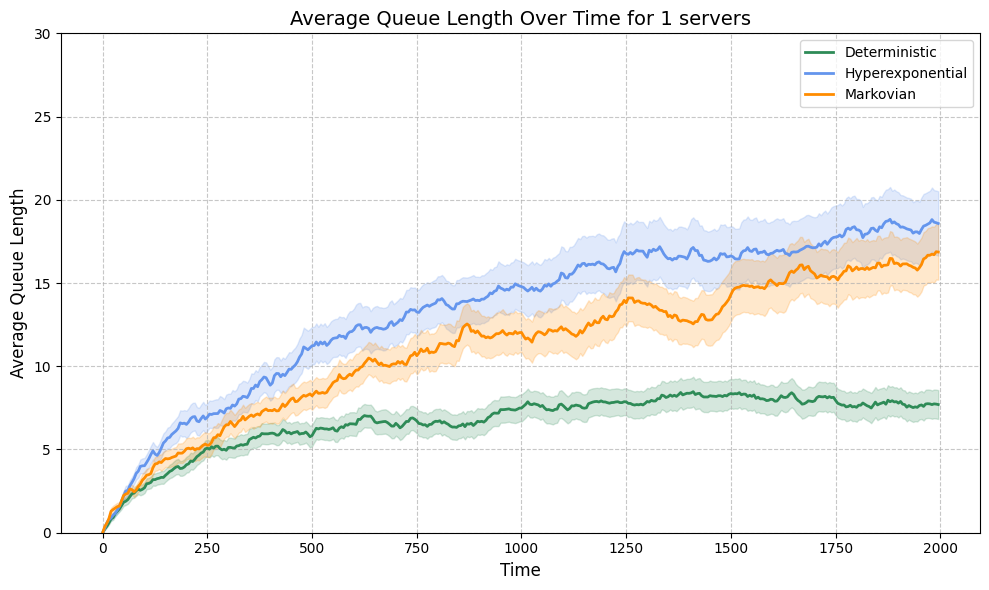

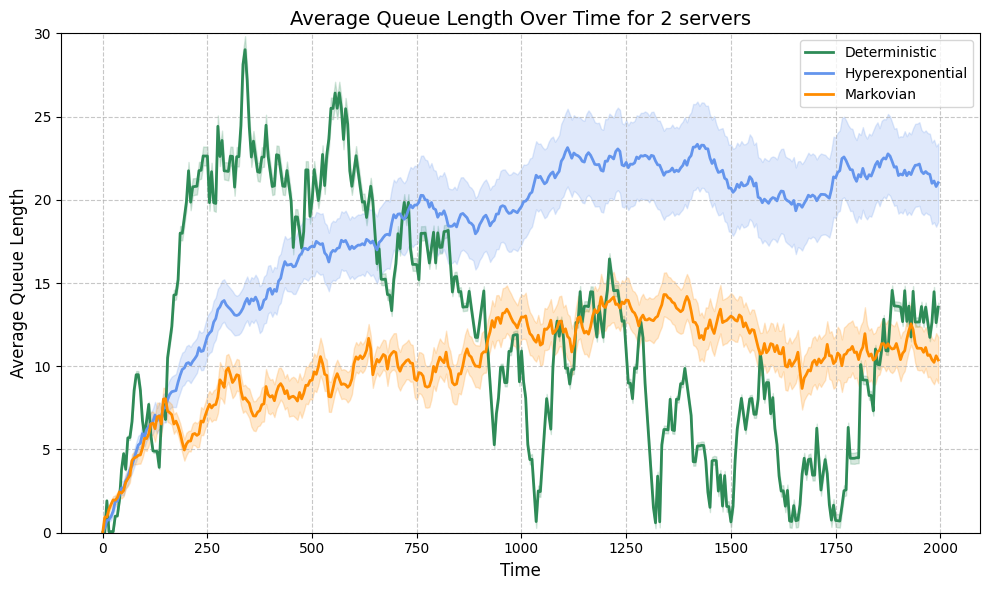

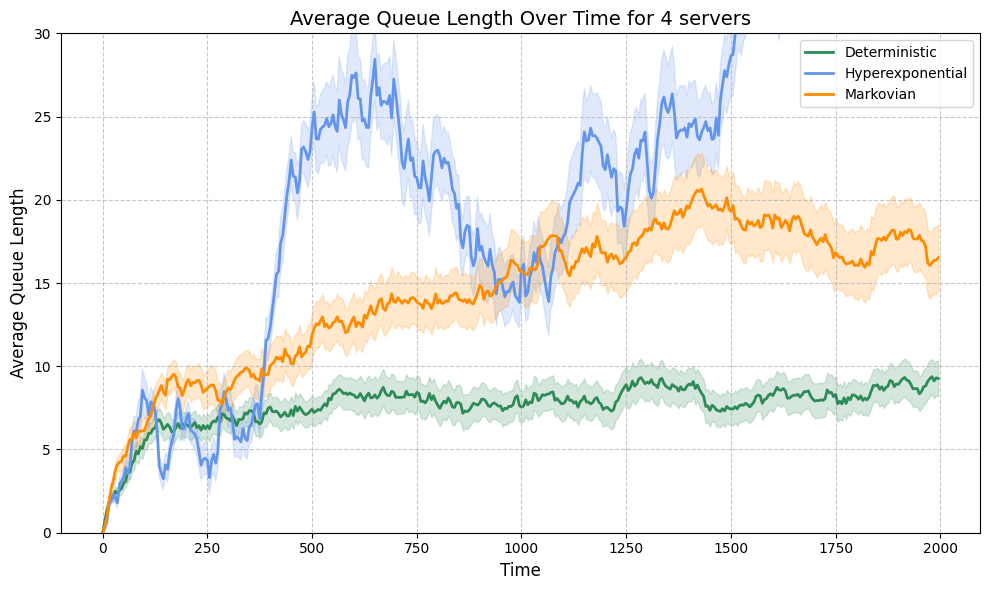

In [6]:
# Compute average queue length and confidence intervals for each time step
colors = ["seagreen", "cornflowerblue", "darkorange"] 



for n in number_of_servers: 
    plt.figure(figsize=(10, 6))
    for server_type in server_types:
        plot_data = {}
        q_lengths_matrix = np.array(queue_length_matrices[server_type][n])
        averages = np.mean(q_lengths_matrix, axis=0)
        std_dev = np.std(q_lengths_matrix, axis=0, ddof=1)
        ci_lower = averages - 1.96 * std_dev / np.sqrt(q_lengths_matrix.shape[0])
        ci_upper = averages + 1.96 * std_dev / np.sqrt(q_lengths_matrix.shape[0])

        time_steps = np.arange(q_lengths_matrix.shape[1]) * measurement_time_interval 

        plot_data[server_type] = {
            "time_steps": time_steps,
            "averages": averages,
            "ci_lower": ci_lower,
            "ci_upper": ci_upper
        }

        time_steps = plot_data[server_type]["time_steps"]
        averages = plot_data[server_type]["averages"]
        ci_lower = plot_data[server_type]["ci_lower"]
        ci_upper = plot_data[server_type]["ci_upper"]

        # Plot averages and confidence intervals
        plt.plot(time_steps, averages, label=f'{server_type}', linewidth=2, color = colors[server_types.index(server_type)])
        plt.fill_between(time_steps, ci_lower, ci_upper, alpha=0.2, color = colors[server_types.index(server_type)])
    # Add plot details
    plt.title(f"Average Queue Length Over Time for {n} servers", fontsize=14)
    plt.ylim(0,30)
    plt.xlabel("Time", fontsize=12)
    plt.ylabel("Average Queue Length", fontsize=12)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig(f"final_opdr4_{n}_servers.png", dpi=300)

    plt.show()



# waiting time

dict_keys(['Deterministic', 'Hyperexponential', 'Markovian'])


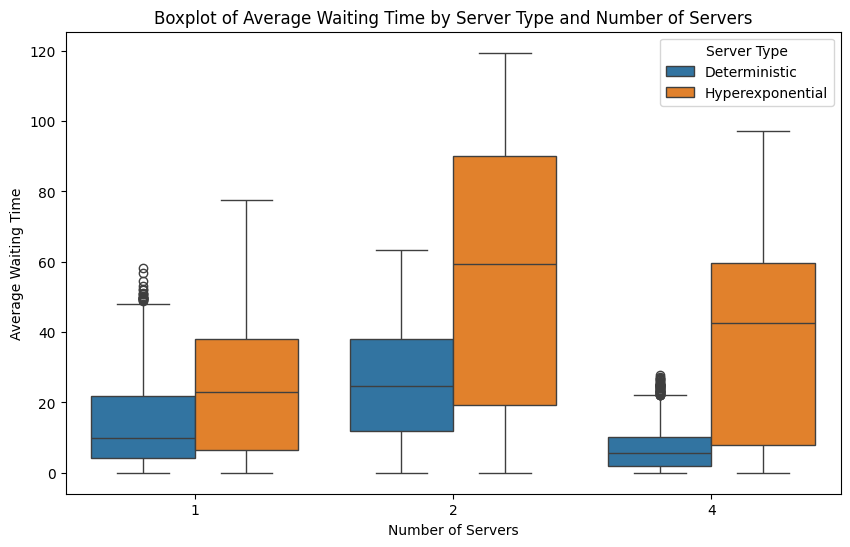

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
server_types = ["Deterministic", "Hyperexponential"]

print(waiting_times_matrices.keys())

# Prepare data for plotting
plot_data = []
for server_type in server_types:
    for n in servers:
        for waiting_time in waiting_times_matrices[server_type][n]:
            plot_data.append([server_type, n, waiting_time])

df = pd.DataFrame(plot_data, columns=["ServerType", "Servers", "AverageWaitingTime"])

# Plot box plot
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x="Servers", y="AverageWaitingTime", hue="ServerType" )
plt.title("Boxplot of Average Waiting Time by Server Type and Number of Servers")
plt.xlabel("Number of Servers")
plt.ylabel("Average Waiting Time")
plt.legend(title="Server Type")
plt.savefig("boxplots3_4", dpi =300)
plt.show()
plt.close()



server_types = ["Deterministic",  "Markovian", "Hyperexponential"]




# Histograms of waiting time

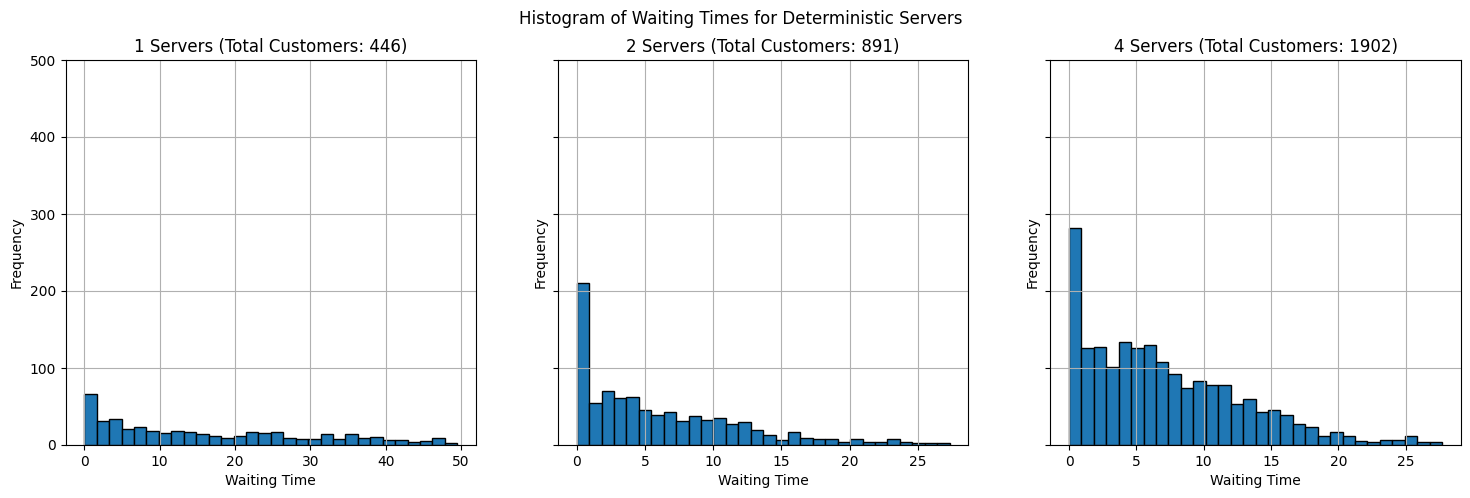

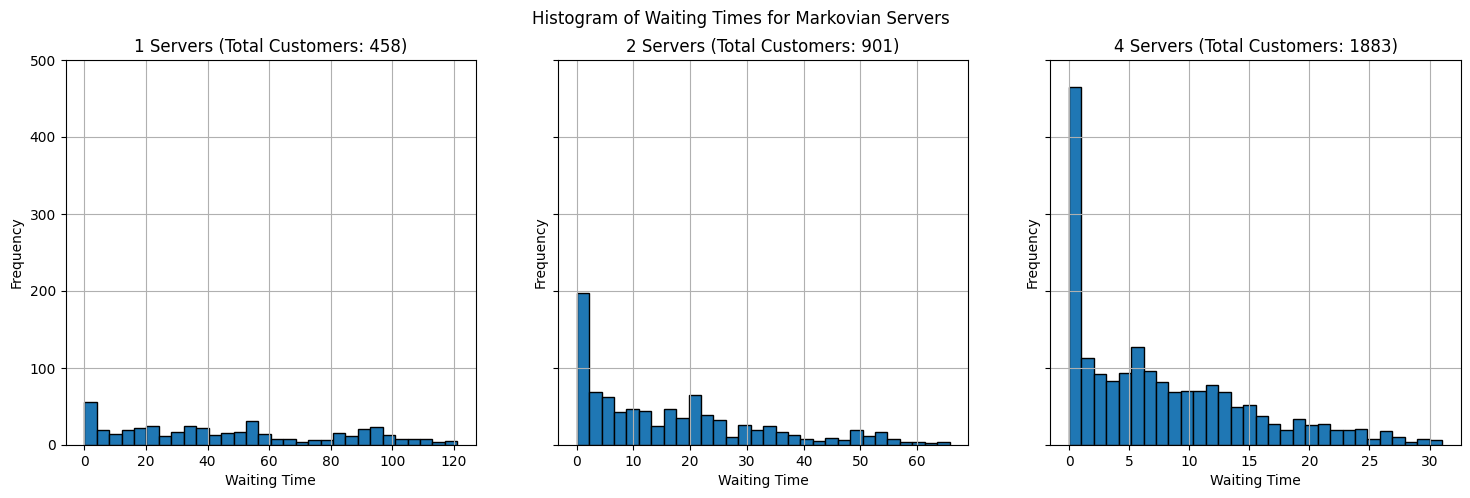

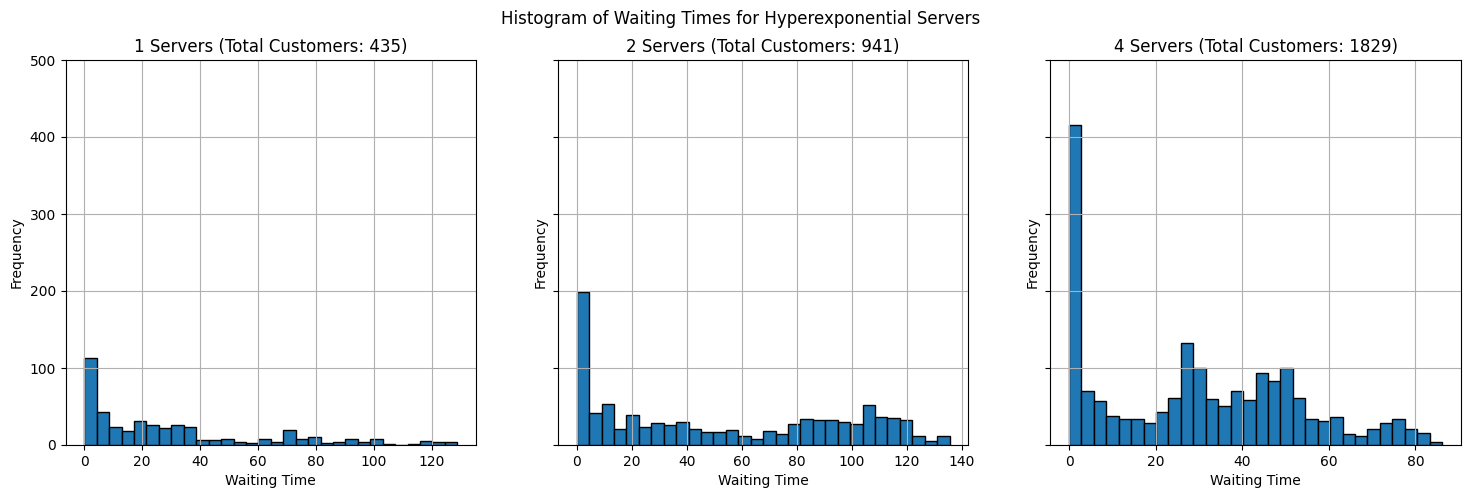

In [8]:
random_seed = 1234

system_load = 0.95
mean_service_time = 4
simulations = 300
servers = [1, 2, 4]
server_types = ["Deterministic",  "Markovian", "Hyperexponential"]
simulation_time = 2000
measurement_time_interval = 5


service_rate = 1 / mean_service_time
mean_interarrival_by_n = {n: 1 / (n * system_load * service_rate) for n in servers}

for server_type in server_types:
    fig, axs = plt.subplots(1, 3, figsize=(18, 5), sharey=True)
    fig.suptitle(f'Histogram of Waiting Times for {server_type} Servers')
    max_y = 0  # To store the maximum y value for setting consistent y-axis limits


    for i, server_count in enumerate(servers):
        specific_mean_interarrival = mean_interarrival_by_n[server_count]

        # Run the simulation for the specific settings
        results = simulate_mmn(specific_mean_interarrival, mean_service_time, server_count, simulation_time, measurement_time_interval, random.randint(0,1000), server_type)
        # Get the waiting times
        #wt = [time for result in results[server_type][server_count] for time in result['waitingtimes']]
        #wt = (results[server_type][server_count])["waitingtimes"]
        wt = results['waitingtimes']
        total_customers = len(wt)
        

        # Create a histogram of the waiting times
        axs[i].hist(wt, bins=30, edgecolor='black')
        axs[i].set_title(f'{server_count} Servers (Total Customers: {total_customers})')
        axs[i].set_xlabel('Waiting Time')
        axs[i].set_ylabel('Frequency')
        axs[i].grid(True)
        axs[i].set_ylim(0,500)
        fig.savefig(f"histogram_{server_type}.png", dpi=300)


    plt.show()
